In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import special

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel

#Power splitting ratio
rho = 0
eps=1
eta=1
print('number of symbols:',M)



number of symbols: 16


In [ ]:
def set_up_train_nn(P,EsNodB):
    label = np.random.randint(M,size=N)

    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)

    # checking data shape
    data = np.array(data)
    print (data.shape)


    # Defined Autoencoder
    batch_size = 4096
    
    # Transmitter Layers
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded2 = Dense(8, activation='relu')(encoded)
    encoded2 = Dense(4, activation='relu')(encoded)
    encoded2 = Dense(2*n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    encoded3 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    # Slicing into CD and PD data, and applying noise

    cd_data = Lambda(lambda x: np.sqrt(rho)*np.sqrt(eps)*x)(encoded3)
    cd_data = Lambda(lambda x: x+K.random_normal_variable((32768*2,2), 0,np.sqrt(0.5))[0:tf.shape(x)[0],:])(cd_data)

    
    pd_data = Lambda(lambda x: K.expand_dims((1-rho)*eta*eps*K.sum(K.square(x),axis=1),axis=1))(encoded3)
    pd_data = Lambda(lambda x: x+K.random_normal_variable((32768*2,1), 0,np.sqrt(0))[0:tf.shape(x)[0]])(pd_data)

    #combining the split data to feed the decoder
    data_split=[]
    data_split.append(cd_data)
    data_split.append(pd_data)

    data_split =  Concatenate(axis=1)(data_split)


    # Reciever Layer
    decoded = Dense(2, activation='linear')(data_split)
    decoded = Dense(4, activation='relu')(decoded)
    decoded = Dense(8, activation='relu')(decoded)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.075)
    sgd = SGD(lr=0.5)
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy','mse'])

    # printing summary of layers and it's trainable parameters 
    print (autoencoder.summary())

    # traning auto encoder
    autoencoder.fit(data, data,
                    epochs=150,
                    batch_size=batch_size)

    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded3)

    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)

    # ploting constellation diagram
    import matplotlib.pyplot as plt
    scatter_plot = scatter_plot.reshape(M,2,1)

    plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' eps = '+str(eps))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    p_av = np.sum(np.square(scatter_plot),axis=1)
    print(sum(p_av)/16)

    return autoencoder

(10000, 16)
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            34          dense_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2)            4           dense_4[0][0]                    
_________________________

10000/10000 [==============================] - 0s 11us/step - loss: 0.8924 - acc: 0.6789 - mean_squared_error: 0.0297
Epoch 34/150
10000/10000 [==============================] - 0s 8us/step - loss: 0.8481 - acc: 0.6774 - mean_squared_error: 0.0286
Epoch 35/150
10000/10000 [==============================] - 0s 11us/step - loss: 0.7816 - acc: 0.7366 - mean_squared_error: 0.0262
Epoch 36/150
10000/10000 [==============================] - 0s 9us/step - loss: 0.7470 - acc: 0.6865 - mean_squared_error: 0.0253
Epoch 37/150
10000/10000 [==============================] - 0s 9us/step - loss: 0.7097 - acc: 0.7689 - mean_squared_error: 0.0238
Epoch 38/150
10000/10000 [==============================] - 0s 9us/step - loss: 0.6887 - acc: 0.7244 - mean_squared_error: 0.0230
Epoch 39/150
10000/10000 [==============================] - 0s 9us/step - loss: 0.6567 - acc: 0.7652 - mean_squared_error: 0.0221
Epoch 40/150
10000/10000 [==============================] - 0s 11us/step - loss: 0.6944 - acc: 0.7244

10000/10000 [==============================] - 0s 11us/step - loss: 0.4827 - acc: 0.7851 - mean_squared_error: 0.0190
Epoch 96/150
10000/10000 [==============================] - 0s 11us/step - loss: 0.4603 - acc: 0.7780 - mean_squared_error: 0.0178
Epoch 97/150
10000/10000 [==============================] - 0s 9us/step - loss: 0.4009 - acc: 0.8089 - mean_squared_error: 0.0152
Epoch 98/150
10000/10000 [==============================] - 0s 11us/step - loss: 0.3331 - acc: 0.8485 - mean_squared_error: 0.0118
Epoch 99/150
10000/10000 [==============================] - 0s 8us/step - loss: 0.4546 - acc: 0.8477 - mean_squared_error: 0.0151
Epoch 100/150
10000/10000 [==============================] - 0s 8us/step - loss: 0.3251 - acc: 0.9119 - mean_squared_error: 0.0114
Epoch 101/150
10000/10000 [==============================] - 0s 9us/step - loss: 0.3420 - acc: 0.8543 - mean_squared_error: 0.0123
Epoch 102/150
10000/10000 [==============================] - 0s 11us/step - loss: 0.2627 - acc: 0.

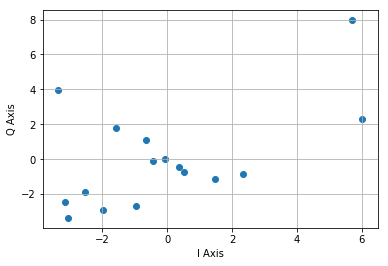

[15.596268]
Es/No: 12 SER: 0.0938 Theor_SER_PAM: 0.5075803579279314
(64000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 16)           272         input_2[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2)            34          dense_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 2)            4           dense_12[0][0]                   
_____________________________

64000/64000 [==============================] - 0s 5us/step - loss: 1.6557 - acc: 0.3746 - mean_squared_error: 0.0391
Epoch 38/150
64000/64000 [==============================] - 0s 5us/step - loss: 1.6552 - acc: 0.3755 - mean_squared_error: 0.0391
Epoch 39/150
64000/64000 [==============================] - 0s 5us/step - loss: 1.6552 - acc: 0.3742 - mean_squared_error: 0.0391
Epoch 40/150
64000/64000 [==============================] - 0s 5us/step - loss: 1.6547 - acc: 0.3744 - mean_squared_error: 0.0391
Epoch 41/150
64000/64000 [==============================] - 0s 5us/step - loss: 1.6545 - acc: 0.3746 - mean_squared_error: 0.0391
Epoch 42/150
64000/64000 [==============================] - 0s 5us/step - loss: 1.6566 - acc: 0.3740 - mean_squared_error: 0.0392
Epoch 43/150
64000/64000 [==============================] - 0s 5us/step - loss: 1.8310 - acc: 0.3455 - mean_squared_error: 0.0431
Epoch 44/150
64000/64000 [==============================] - 0s 5us/step - loss: 1.8265 - acc: 0.3193 - 

64000/64000 [==============================] - 0s 3us/step - loss: 3.1409 - acc: 0.1603 - mean_squared_error: 0.0575
Epoch 101/150
64000/64000 [==============================] - 0s 3us/step - loss: 2.3534 - acc: 0.1821 - mean_squared_error: 0.0522
Epoch 102/150
64000/64000 [==============================] - 0s 3us/step - loss: 2.1642 - acc: 0.2213 - mean_squared_error: 0.0495
Epoch 103/150
64000/64000 [==============================] - 0s 3us/step - loss: 2.1218 - acc: 0.2447 - mean_squared_error: 0.0478
Epoch 104/150
64000/64000 [==============================] - 0s 3us/step - loss: 2.0949 - acc: 0.2487 - mean_squared_error: 0.0470
Epoch 105/150
64000/64000 [==============================] - 0s 3us/step - loss: 2.2246 - acc: 0.2266 - mean_squared_error: 0.0493
Epoch 106/150
64000/64000 [==============================] - 0s 3us/step - loss: 2.3702 - acc: 0.1532 - mean_squared_error: 0.0553
Epoch 107/150
64000/64000 [==============================] - 0s 3us/step - loss: 2.3136 - acc: 0.

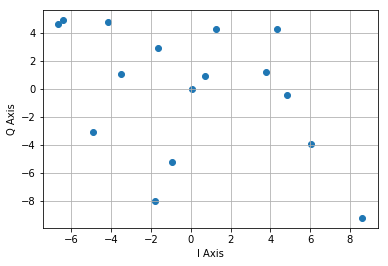

[39.53829]
Es/No: 16 SER: 0.8122140625 Theor_SER_PAM: 0.3123019621637889
(60000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 16)           272         input_3[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 2)            34          dense_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 2)            4           dense_20[0][0]                   
________________________

60000/60000 [==============================] - 0s 3us/step - loss: 2.3079 - acc: 0.1914 - mean_squared_error: 0.0507
Epoch 38/150
60000/60000 [==============================] - 0s 3us/step - loss: 2.3079 - acc: 0.1892 - mean_squared_error: 0.0507
Epoch 39/150
60000/60000 [==============================] - 0s 3us/step - loss: 2.3079 - acc: 0.1893 - mean_squared_error: 0.0507
Epoch 40/150
60000/60000 [==============================] - 0s 3us/step - loss: 2.3081 - acc: 0.1901 - mean_squared_error: 0.0507
Epoch 41/150
60000/60000 [==============================] - 0s 4us/step - loss: 2.3080 - acc: 0.1910 - mean_squared_error: 0.0507
Epoch 42/150
60000/60000 [==============================] - 0s 4us/step - loss: 2.3077 - acc: 0.1897 - mean_squared_error: 0.0507
Epoch 43/150
60000/60000 [==============================] - 0s 4us/step - loss: 2.3079 - acc: 0.1886 - mean_squared_error: 0.0507
Epoch 44/150
60000/60000 [==============================] - 0s 3us/step - loss: 2.3081 - acc: 0.1884 - 

60000/60000 [==============================] - 0s 4us/step - loss: 2.3079 - acc: 0.1905 - mean_squared_error: 0.0507
Epoch 101/150
60000/60000 [==============================] - 0s 3us/step - loss: 2.3075 - acc: 0.1895 - mean_squared_error: 0.0507
Epoch 102/150
60000/60000 [==============================] - 0s 3us/step - loss: 2.3078 - acc: 0.1873 - mean_squared_error: 0.0507
Epoch 103/150
60000/60000 [==============================] - 0s 3us/step - loss: 2.3077 - acc: 0.1902 - mean_squared_error: 0.0507
Epoch 104/150
60000/60000 [==============================] - 0s 4us/step - loss: 2.3075 - acc: 0.1883 - mean_squared_error: 0.0507
Epoch 105/150
60000/60000 [==============================] - 0s 6us/step - loss: 2.3079 - acc: 0.1891 - mean_squared_error: 0.0507
Epoch 106/150
60000/60000 [==============================] - 0s 3us/step - loss: 2.3080 - acc: 0.1872 - mean_squared_error: 0.0507
Epoch 107/150
60000/60000 [==============================] - 0s 3us/step - loss: 2.3080 - acc: 0.

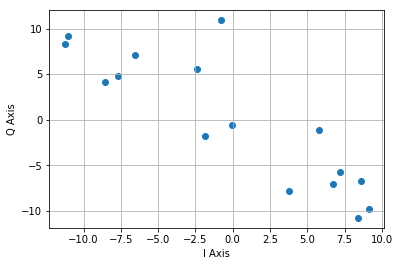

[100.241974]


In [ ]:
EsNodB_range = [12,16,20,25,26]
N_array=[10000,64000,60000,20000,15000,16000]
ser = [None]*len(EsNodB_range)
theor_ser_qam = [None]*len(EsNodB_range)
theor_ser = [None]*len(EsNodB_range)

noise_std = np.sqrt(1)
for n in range(0,len(EsNodB_range)):
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    
    no_errors = 0
    
    N=N_array[n]
   
    
    autoencoder = set_up_train_nn(P,EsNodB_range[n])
    
    # generating data for checking SER
    N=N*10
    test_label = np.random.randint(M,size=N)
    test_data = []

    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = no_errors / N 
    
    P_sqrtM = 0.75*special.erfc(np.sqrt(EsNo/10))
    theor_ser_qam[n] = 1-(1-P_sqrtM)**2
    theor_ser[n] = (15/16)*special.erfc(np.sqrt(EsNo/85))
    
    print ('Es/No:',EsNodB_range[n],'SER:',ser[n],'Theor_SER_PAM:',theor_ser[n])
    

In [ ]:
plt.plot(EsNodB_range, theor_ser, 'g--',label='16 PAM')
plt.plot(EsNodB_range, ser, 'bo-',label='Conventional PD-both streams')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()

In [ ]:
ser